In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.tri as tri
# from matplotlib import cm
# from matplotlib import rc

import seaborn as sns
sns.set_theme(style="white", font_scale=1.5)
sns.set_palette("Set2")
# rc('text', usetex=True)
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
from collections import defaultdict

from constrained.nonnegative.entropic import NonnegativeEntropicMap
from constrained.sampling.svgd import svgd_update, proj_svgd_update
from constrained.sampling.svmd import svmd_update
from constrained.sampling.kernel import imq
from constrained.target import Target
from utils import energy_dist

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
class SelectiveTarget(Target):
    def __init__(self, A, b, noise_scale):
        self.A = tf.constant(A, dtype=tf.float64)
        self.b = tf.constant(b, dtype=tf.float64)
        self.noise_scale = tf.constant(noise_scale, dtype=tf.float64)
        super(SelectiveTarget, self).__init__(NonnegativeEntropicMap())

    def logp(self, theta):
        # theta: [..., K, D]
        # ret: [..., K]
        recon = tf.einsum("...ki,ji->...kj", theta, self.A) + self.b
        return -0.5 * tf.reduce_sum(tf.square(recon), axis=-1) / tf.square(self.noise_scale)

    def grad_logp(self, theta):
        # ret: [..., K, D]
        # recon = theta @ tf.transpose(self.A) + self.b
        recon = tf.einsum("...ki,ji->...kj", theta, self.A) + self.b
        # ret = -recon @ self.A / tf.square(self.noise_scale)
        ret = -tf.einsum("...kj,ji->...ki", recon, self.A) / tf.square(self.noise_scale)
        return ret

In [3]:
data = np.load("sel.npz")
A = data["linear"]
b = np.squeeze(data["offset"], -1)
noise_scale = data["noise_scale"]
theta_init = data["init"]
print("A:", A.shape)
print("b:", b.shape)
print("A:", A)
print("b:", b)
print("theta_init:", theta_init)
print("noise_scale:", noise_scale)

A: (2, 2)
b: (2,)
A: [[ 2.39859464 -1.90815867]
 [ 0.          1.18099191]]
b: [ 2.39751093 -1.46103937]
theta_init: [0.30883085 1.4801243 ]
noise_scale: 0.2488836156425015


In [4]:
K = 50
D = b.shape[0]
print("K:", K)
print("D:", D)

target = SelectiveTarget(A, b, noise_scale)

K: 50
D: 2


2023-02-13 02:09:20.058761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 02:09:22.720094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11423 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-02-13 02:09:22.722543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11423 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-02-13 02:09:22.724951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 wit

In [5]:
# Initialize the HMC transition kernel.
num_results = 100
num_burnin_steps = 1000
num_steps_between_results = 5
adaptive_hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=lambda x: target.dual_logp(x),
#         num_leapfrog_steps=10,
        step_size=0.01)#,
    #num_adaptation_steps=int(2000))

# Run the chain (with burn-in).
@tf.function(experimental_compile=True)
def run_chain():
    samples, pkr = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_steps_between_results,
        current_state=np.zeros([10, D], dtype=np.float64),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr)
    return samples, pkr

eta_samples, pkr = run_chain()

2023-02-13 02:09:24.210592: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55ee2cf0b7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-13 02:09:24.210637: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 02:09:24.210650: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 02:09:24.210660: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (2): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 02:09:24.210670: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (3): NVIDIA TITAN Xp, Compute Capability 6.1
2023-02-13 02:09:24.269903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-13 02:09:24.307942: W tens

In [6]:
# is_accepted = pkr.inner_results.is_accepted
r_hat = tfp.mcmc.potential_scale_reduction(eta_samples)
print("chain:", eta_samples.shape)
# print("acceptance rate:", is_accepted.numpy().mean())
print("R-hat diagnostic (per dim):", r_hat.numpy())

theta_hmc = target.mirror_map.nabla_psi_star(tf.reshape(eta_samples, [-1, D]))

chain: (100, 10, 2)
R-hat diagnostic (per dim): [1.00419635 0.99961765]


(0.8, 2.2)

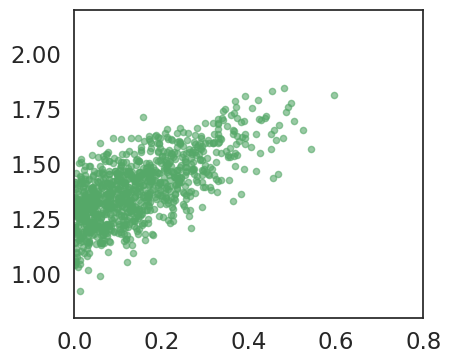

In [7]:
f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
theta_hmc_np = theta_hmc.numpy()[:, :2]
ax.scatter(theta_hmc_np[:, 0], theta_hmc_np[:, 1], alpha=.6, c="g", s=20)
ax.set_xlim([0, 0.8])
ax.set_ylim([0.8, 2.2])

In [8]:
def run(target, ground_truth_set, method="smvd", lr=0.005, n_chain=10):
    eta0 = target.mirror_map.nabla_psi(theta_init[None, :]) + tf.random.normal([n_chain, K, D], dtype=tf.float64)
    # eta: [n_chain, K, D - 1]
    eta = tf.Variable(eta0)
    theta0 = target.mirror_map.nabla_psi_star(eta0)
    if method == "proj_svgd":
        theta = tf.Variable(theta0)
    else:
        theta = theta0
        # eta: [n_chain, K, D - 1]
        eta = tf.Variable(eta0)
    n_iters = 1000
    kernel = imq
    eds = []
    trange = tqdm(range(n_iters))
    optimizer = tf.keras.optimizers.RMSprop(lr)
    kernel_width2 = 0.01

    for t in trange:
        if method == "svmd":
            eta_grad = svmd_update(target, theta, kernel, n_eigen_threshold=0.99, kernel_width2=kernel_width2)
        elif method == "msvgd":
            eta_grad = svgd_update(target, eta, theta, kernel, kernel_width2=kernel_width2)
        elif method == "proj_svgd":
            theta_grad = proj_svgd_update(target, theta, kernel, kernel_width2=kernel_width2)
        else:
            raise NotImplementedError()

        if method == "proj_svgd":
            optimizer.apply_gradients([(-theta_grad, theta)])
            theta.assign(tf.maximum(theta, 0.))
        else:
            optimizer.apply_gradients([(-eta_grad, eta)])
            theta = target.mirror_map.nabla_psi_star(eta)
        if t % 20 == 0:
            ed = energy_dist(ground_truth_set, theta[0])
            eds.append(ed.numpy())
    return tf.reshape(theta, [-1, theta.shape[-1]]), eds

In [9]:
methods = ["proj_svgd", "svmd", "msvgd"]

In [10]:
ground_truth_set = theta_hmc

search_lr = [0.1, 0.01, 0.001]
samples_dict = defaultdict(list)
eds_dict = defaultdict(list)

for method in methods:
    # if method == "proj_svgd":
    #     search_lr = [0.01, 0.001, 1e-4]
    for lr in search_lr:
        theta, eds = run(target, ground_truth_set, method=method, lr=lr)
        eds_dict[method].append(eds)
        samples_dict[method].append(theta)

  0%|          | 0/1000 [00:00<?, ?it/s]2023-02-13 02:10:08.222431: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f04f8080c10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-13 02:10:08.222489: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
100%|██████████| 1000/1000 [00:05<00:00, 184.13it/s]


In [11]:
name_map = {
    "msvgd": "MSVGD",
    "svmd": "SVMD",
    "proj_svgd": "SVGD w/ proj."
}

In [12]:
# np.set_printoptions(precision=3, suppress=True)
# print(samples_svgd[0].numpy()[:50])

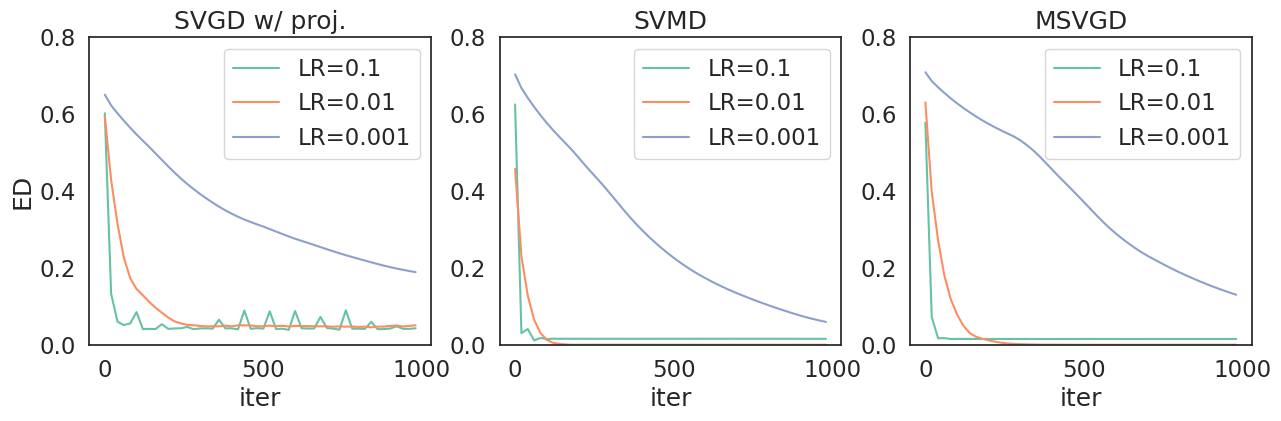

In [13]:
f, axes = plt.subplots(1, len(methods), figsize=(5 * len(methods), 4))

for i, method in enumerate(methods):
    search_lr_ = [0.1, 0.01, 0.001]
    for j, lr in enumerate(search_lr_):
        axes[i].plot(np.arange(len(eds_dict[method][0])) * 20, eds_dict[method][j], label="LR={}".format(lr))
    axes[i].set_title(name_map[method])
    axes[i].set_ylim(top=0.8, bottom=0)
    axes[i].set_xlabel("iter")
    if i == 0:
        axes[i].set_ylabel("ED")
    axes[i].legend()

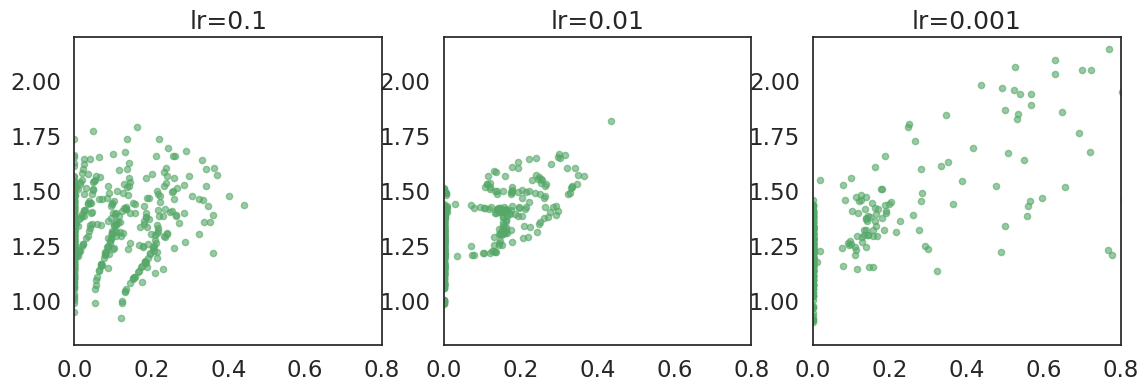

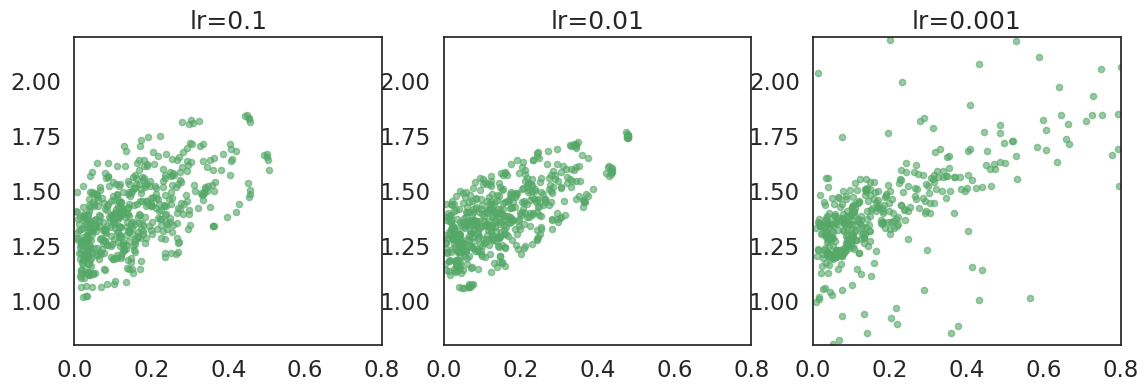

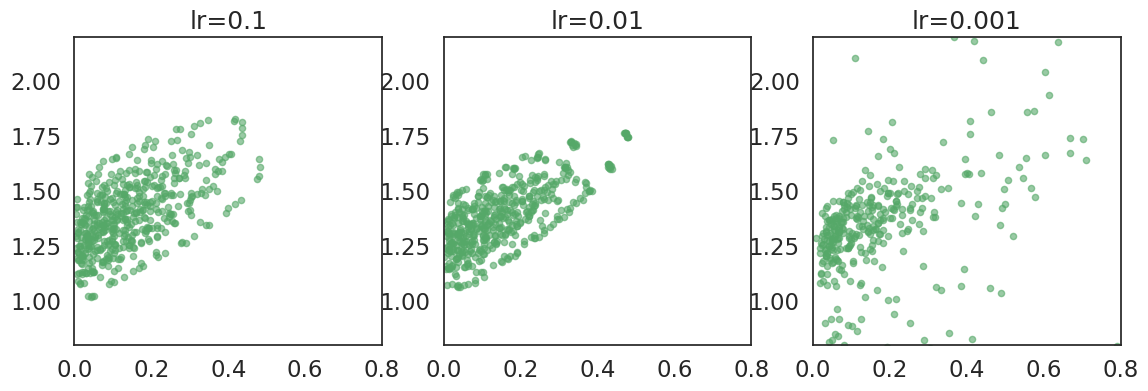

In [14]:
for method in methods:
    f, axes = plt.subplots(1, len(search_lr), figsize=(4.5 * len(search_lr), 4))
    for i, samples in enumerate(samples_dict[method]):
        samples_np = samples.numpy()
        axes[i].scatter(samples_np[:, 0], samples_np[:, 1], alpha=.6, c="g", s=20)
        axes[i].set_xlim([0, 0.8])
        axes[i].set_ylim([0.8, 2.2])
        axes[i].set_title("lr={}".format(search_lr[i]))

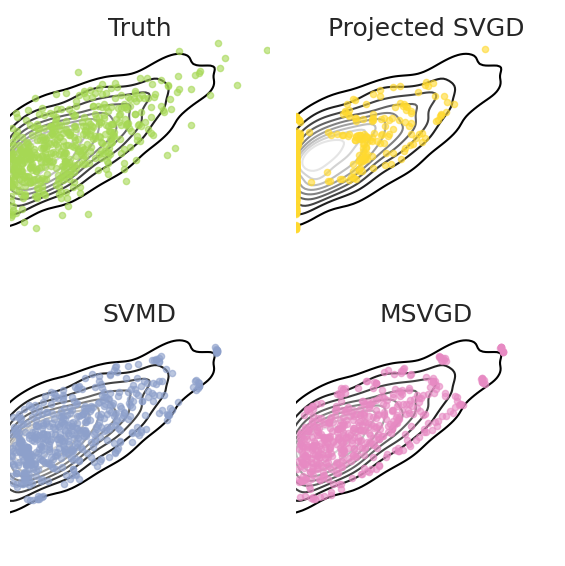

In [15]:
name_map = {
    "msvgd": "MSVGD",
    "svmd": "SVMD",
    "truth": "Truth",
    "proj_svgd": "Projected SVGD",
}

f, axes = plt.subplots(2, 2, figsize=(3 * 2, 3 * 2), sharex=True, sharey=True)
axes = np.ravel(axes)
palette = sns.color_palette("Set2", 6)[-4:]
for i, method in enumerate(["truth"] + methods):
    # cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    # cmap = sns.light_palette(color='#8da0cb',n_colors=7,reverse=False,input='RGB', as_cmap=True)
    sns.kdeplot(x=theta_hmc_np[:, 0], y=theta_hmc_np[:, 1], cmap="Greys_r", levels=10, cut=10, fill=False, ax=axes[i], zorder=1)
    if i == 0:
        samples = theta_hmc_np[:500, :]
    else:
        samples = samples_dict[method][1].numpy()
    # sns.scatterplot(x=samples[:, 0], y=samples[:, 1], s=6, color="0.1", ax=axes[i])
    axes[i].scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=20, color=palette[(2 + i) % 4], zorder=2)
    axes[i].set_xlim([0, 0.6])
    axes[i].set_ylim([0.8, 2])
    axes[i].set_axis_off()
    # axes[i].set_title(name_map[method], position=(0.5, 0.9))
    axes[i].text(.5, .9, name_map[method], horizontalalignment='center', transform=axes[i].transAxes)
plt.tight_layout()
# plt.savefig("sel2d.pdf", bbox_inches="tight", dpi=150)